## Network Callouts 1

- Ok I'm not sure why but getting the main visual together here is proving pretty slippery!
- I'm going to push through the "callouts", then figure out what to show for architecture
- What makes the callouts hard, but also important and powerful I think is connecting visualizations of real data moving through the network with the trigonometry.

### Attack Plan
1. Show clear sines/cosines of each input earlier in the network. Scatter plots and/or time series. Compare raw signal visually to analytical fit. I guess it might be interseting here too to do the 2d/3d plots, we'll see. 
2. Show product terms in the middle of the network. Does it matter if I find all 4? Might be nice we'll see. Again I want the analytical fit equation here. I do think at this point I should export numpy arrays and try something in manim -> this working or not could make a big difference. If it's too noisy, crazy, compare to an analytical lower frequency -> this can help me decide if it make sense to train more models and hunt for lower frequencies. One nice thing about the manim/surface approach is that I think I can show product decomposition really nicely! This step will take some time, and that's ok.
3. Show a spot or two where the network is clearly adding product terms together to cancel out some symmetry and create diagonal symmetry -> big deal! Depending on how part (2) goes, try manim surface again. Again I want analytical fit equation/approximation. 
4. Logit part is fuzzy, but I think it will be manage-able. 

In [32]:
import os
import sys
from functools import partial
from pathlib import Path

import transformer_lens
import einops
import numpy as np
import torch as t
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('/home/stephen/ARENA_3.0/chapter1_transformer_interp/exercises') #Point to some Arena helpers!
import part52_grokking_and_modular_arithmetic.utils as utils

In [104]:
def fourier_approx_1d(x, num_freqs):
    """
    x: 1D real array, length N
    num_freqs: number of *unique* frequency modes to keep (by magnitude),
               counting k>0 and N-k as one mode.

    Returns:
        F_sparse: sparse 1D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    N = len(x)
    F = np.fft.fft(x)

    # Unique freqs for real signals: 0..N//2 (if even) or 0..(N-1)//2 (if odd)
    if N % 2 == 0:
        max_k = N // 2
    else:
        max_k = (N - 1) // 2

    ks = np.arange(0, max_k + 1)
    mags = np.abs(F[ks])

    # Sort unique ks by magnitude (descending)
    idx_sorted = np.argsort(mags)[::-1]
    keep_ks = ks[idx_sorted[:num_freqs]]

    # Build sparse spectrum, preserving conjugate pairs
    F_sparse = np.zeros_like(F, dtype=complex)
    for k in keep_ks:
        F_sparse[k] = F[k]
        # DC and Nyquist have no distinct conjugate partner
        if k != 0 and not (N % 2 == 0 and k == N // 2):
            F_sparse[-k] = F[-k]

    x_hat = np.fft.ifft(F_sparse).real
    return F_sparse, x_hat


def spectrum_to_terms_1d(F_sparse):
    N = len(F_sparse)

    if N % 2 == 0:
        max_k = N // 2
    else:
        max_k = (N - 1) // 2

    terms = []

    for k in range(0, max_k + 1):
        c = F_sparse[k]
        if c == 0:
            continue

        if k == 0 or (N % 2 == 0 and k == N // 2):
            amp = np.abs(c) / N
        else:
            amp = 2 * np.abs(c) / N

        phase = np.angle(c)

        terms.append({
            "k": k,
            "amplitude": amp,
            "phase": phase
        })

    return terms


def generate_python_reconstructor_1d(terms, N, func_name="recon_func_1d", decimals=4):
    lines = []
    lines.append(f"def {func_name}(i):")

    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        k = t["k"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        line = f"        {A} * np.cos(2*np.pi*(({k}*i)/{N}) + {phi}) +"
        lines.append(line)

    lines[-1] = lines[-1].rstrip(" +")
    lines.append("    )")

    return "\n".join(lines)

def fourier_approx_2d(x, num_freqs):
    """
    x: 2D real array, shape (Nx, Ny)
    num_freqs: number of Fourier coefficients to keep (by magnitude)

    Returns:
        F_sparse: sparse 2D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    # 2D FFT
    F = np.fft.fft2(x)
    
    # Flatten and sort coefficients by magnitude (descending)
    flat = F.ravel()
    idx_sorted = np.argsort(np.abs(flat))[::-1]
    
    # Indices of top num_freqs coefficients
    keep_idx = idx_sorted[:num_freqs]
    
    # Build sparse spectrum
    flat_sparse = np.zeros_like(flat, dtype=complex)
    flat_sparse[keep_idx] = flat[keep_idx]
    F_sparse = flat_sparse.reshape(F.shape)
    
    # Reconstruct (take real part to remove tiny numerical imaginary noise)
    x_hat = np.fft.ifft2(F_sparse).real
    
    return F_sparse, x_hat

def spectrum_to_terms(F_sparse):
    """
    Turn a sparse spectrum into a list of (kx, ky, amplitude, phase) terms.
    Only nonzero entries are returned.
    """
    Nx, Ny = F_sparse.shape
    terms = []
    
    for (kx, ky), c in np.ndenumerate(F_sparse):
        if c == 0:
            continue
        amp = np.abs(c) / (Nx * Ny)   # matches np.fft normalization
        phase = np.angle(c)
        terms.append({
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase
        })
    
    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit cosine terms from a sparse Fourier representation.
    """

    lines = []
    # lines.append("import numpy as np\n")
    lines.append(f"def {func_name}(i, j):")
    
    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        # One cosine term
        line = (
            f"        {A} * np.cos(2*np.pi*((({kx}*i)/{Nx}) + "
            f"(({ky}*j)/{Ny})) + {phi}) +"
        )
        lines.append(line)

    # Remove trailing '+'
    lines[-1] = lines[-1].rstrip(" +")

    lines.append("    )")

    return "\n".join(lines)

# def reconstruction_error(x, x_hat, remove_mean=True):
#     if remove_mean:
#         x=x-x.mean(); x_hat=x_hat-x_hat.mean()
#     diff = x - x_hat
#     mse = np.mean(diff**2)
#     rel_l2 = np.linalg.norm(diff) / np.linalg.norm(x)
#     return mse, rel_l2

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
t.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [3]:
p = 113

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

model = HookedTransformer(cfg)

In [4]:
REPO_ID = "callummcdougall/grokking_full_run_data"
FILENAME = "full_run_data.pth"

local_dir = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

full_run_data = t.load(local_dir, weights_only=True)
state_dict = full_run_data["state_dicts"][400]

model = utils.load_in_state_dict(model, state_dict)

In [5]:
# Get all data and labels, and cache activations
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

# Final position only, also remove the logits for `=`
original_logits = original_logits[:, -1, :-1]

# Get cross entropy loss
original_loss = utils.cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item():.3e}")

Original loss: 2.412e-07


In [6]:
# Helper variables
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos
W_E = model.W_E[:-1]
final_pos_resid_initial = model.W_E[-1] + W_pos[2]
W_U = model.W_U[:, :-1]

#Functional Form
W_logit = W_out @ W_U

W_OV = W_V @ W_O
W_neur = W_E @ W_OV @ W_in

W_QK = W_Q @ W_K.transpose(-1, -2)
W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5)

In [7]:
m = all_data[:, 0]          # (N,)
n = all_data[:, 1]          # (N,)

t0 = F.one_hot(m, num_classes=p).float()   # (N, p)
t1 = F.one_hot(n, num_classes=p).float()   # (N, p)

# ----- 2. Compute alpha per head: α^h = σ(W_attn^h (t0 - t1)) -----
# diff: (N, p)
diff = t0 - t1

# W_attn: (n_heads, p)
# diff @ W_attn.T → (N, n_heads)
alpha = t.sigmoid(diff @ W_attn.T)         # (N, n_heads)

# For broadcasting later: (N, n_heads, 1)
alpha = alpha.unsqueeze(-1)

# ----- 3. Mix tokens per head: α^h t0 + (1-α^h) t1 -----
# Expand t0, t1 to (N, 1, p) to broadcast across heads
t0_exp = t0.unsqueeze(1)                   # (N, 1, p)
t1_exp = t1.unsqueeze(1)                   # (N, 1, p)

# token_mix: (N, n_heads, p)
token_mix = alpha * t0_exp + (1.0 - alpha) * t1_exp

# ----- 4. Map token_mix through W_neur -----
# W_neur: (n_heads, p, d_mlp)
# We want: (N, n_heads, d_mlp)
#
# Using einsum:
#  'nhp, hpd -> nhd'
neur_acts = t.einsum("nhp,hpd->nhd", token_mix, W_neur)  # (N, n_heads, d_mlp)

# Sum over heads: (N, d_mlp)
pre_mlp = neur_acts.sum(dim=1)

# ----- 5. ReLU, then logit projection -----
hidden = F.relu(pre_mlp)                  # (N, d_mlp)
logits = hidden @ W_logit                # (N, p)

In [8]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


## 1. Sines and Cosines

Show clear sines/cosines of each input earlier in the network. Scatter plots and/or time series. Compare raw signal visually to analytical fit. I guess it might be interseting here too to do the 2d/3d plots, we'll see. 

Let me double check that hook embed won't work. 

In [16]:
# mr = einops.rearrange(cache['hook_embed'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

# fig=plt.figure(0, (12,12))
# for i in range(12):
#     for j in range(12):
#         fig.add_subplot(12,12,12*i+j+1)
#         plt.scatter(mr[0, :, 1, i], mr[0, :, 1, j], c=range(113), s=1)
#         plt.axis('off')

# Yeah, no go, that's ok

In [17]:
W_neur.shape

torch.Size([4, 113, 512])

In [18]:
m=W_neur[1].detach().cpu().numpy()

In [19]:
m.shape

(113, 512)

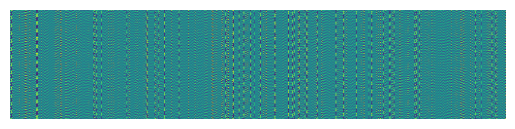

In [23]:
plt.imshow(m); plt.axis('off')
plt.savefig('/home/stephen/grokking/nov_25_1/w_neur_1.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_67234/1813589760.py:3: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (12,12))


<Figure size 640x480 with 0 Axes>

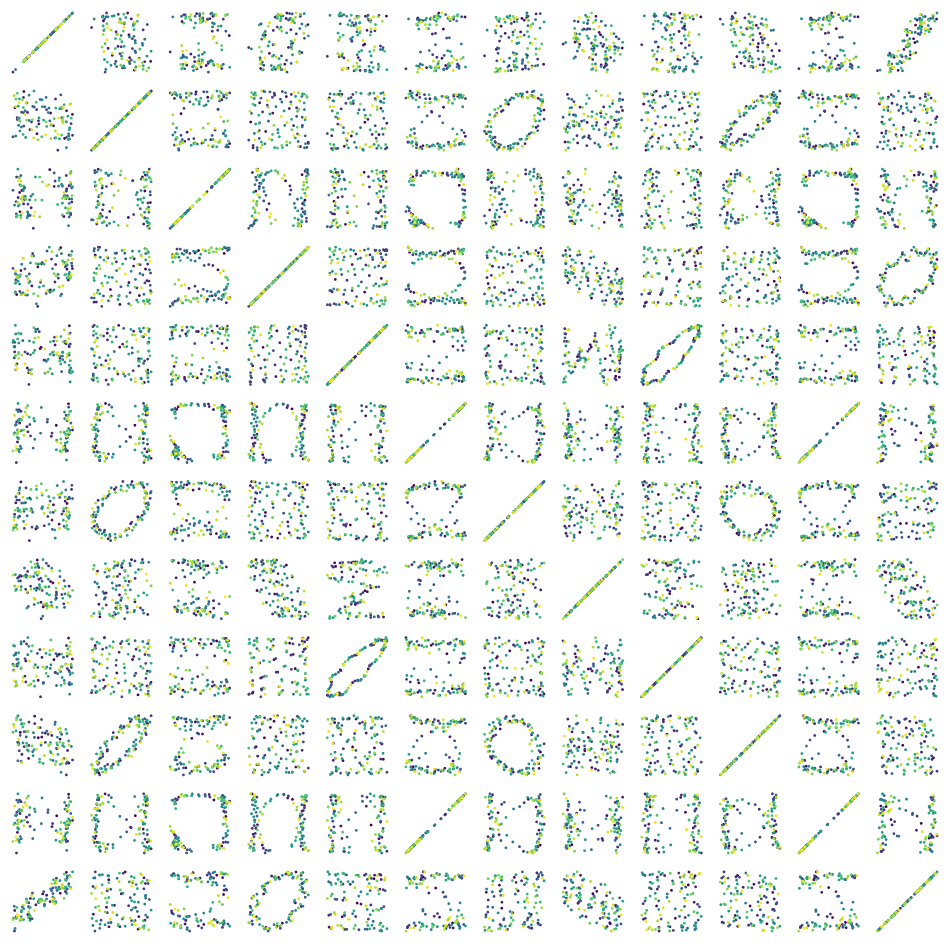

In [25]:
for fig_count in range(8): 
    plt.clf()
    fig=plt.figure(0, (12,12))
    for i in range(12):
        for j in range(12):
            fig.add_subplot(12,12,12*i+j+1)
            plt.scatter(m[:,i+12*fig_count], m[:, j+12*fig_count], c=range(113), s=1)
            plt.axis('off')
    plt.savefig('/home/stephen/grokking/nov_25_1/w_neur_scatter_'+str(fig_count)+'.png', dpi=300, bbox_inches='tight')

In [28]:
neuron_idx=2
sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()

F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [29]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.4386 * np.cos(2*np.pi*((42*i)/113) + -2.0755)
    )


In [33]:
head_index=1
res=[]
for neuron_idx in range(512):
    sig=W_neur[head_index][:,neuron_idx].detach().cpu().numpy()
    
    F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
    terms_1d = spectrum_to_terms_1d(F_sparse)
    terms_1d[0]['neuron_idx']=neuron_idx
    terms_1d[0]['err']=np.linalg.norm(sig-x_hat)/np.linalg.norm(sig)
    res.append(terms_1d[0])
df=pd.DataFrame(res)

In [41]:
df_k14 = df[df["k"] == 14]
df_k14.iloc[df_k14['err'].argsort()][:10]

k  amplitude     phase  neuron_idx       err
241  14   1.943125 -2.843020         241  0.179858
501  14   1.668353 -2.957681         501  0.203160
222  14   1.768401  2.670051         222  0.218978
291  14   1.947914 -3.038899         291  0.227148
317  14   1.724446  0.687975         317  0.229569
480  14   1.758056 -1.857404         480  0.230142
248  14   1.944216  2.914293         248  0.230302
486  14   1.265198 -1.846968         486  0.230346
293  14   1.775200 -1.802208         293  0.231595
149  14   1.341949  0.672559         149  0.233556

In [58]:
neuron_idx=317

sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()
F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [59]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.7244 * np.cos(2*np.pi*((14*i)/113) + 0.688)
    )


In [63]:
def recon_func_1d(i):
    return (
        1.7244 * np.cos(2*np.pi*((14*i)/113) + 0.688)
    )

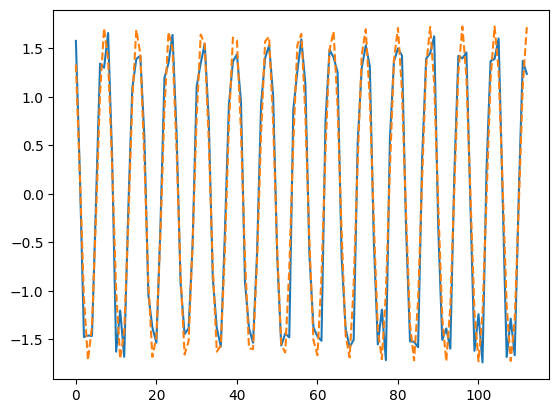

In [64]:
plt.plot(sig)
plt.plot(recon_func_1d(np.arange(p)), '--')

In [67]:
neuron_idx=293

sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()
F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [68]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.7752 * np.cos(2*np.pi*((14*i)/113) + -1.8022)
    )


In [69]:
def recon_func_1d(i):
    return (
        1.7752 * np.cos(2*np.pi*((14*i)/113) + -1.8022)
    )

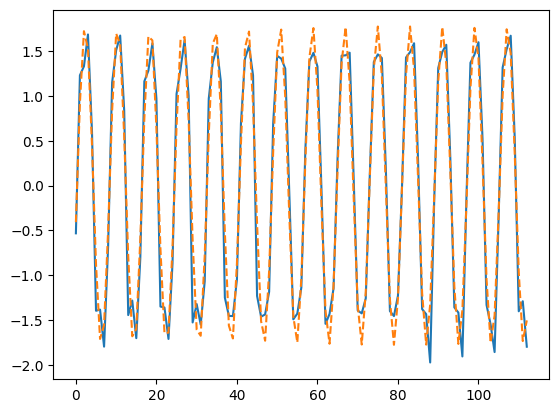

In [70]:
plt.plot(sig)
plt.plot(recon_func_1d(np.arange(p)), '--')

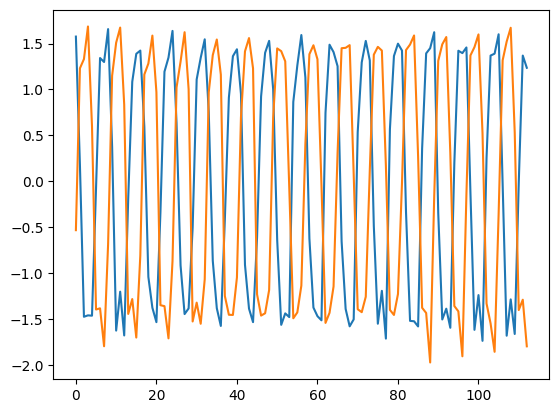

In [75]:
#Ok nice -> yeah I feel like drawing these together would be pretty dope! Really nice. 
plt.plot(W_neur[1][:,317].detach().cpu().numpy())
plt.plot(W_neur[1][:,293].detach().cpu().numpy())

- Ok dope, those are nice clean sine and cosine examples.
- Hmm I guess I'll want them in manim probably? Yeah let me go ahead and wrangle a little numpy export.
- I guess I could just export the whole weights array? That's probably cleanest. 

In [73]:
np.save('/home/stephen/grokking/nov_25_1/W_nuer', W_neur[1].detach().cpu().numpy())

## 2. Products

Show product terms in the middle of the network. Does it matter if I find all 4? Might be nice we'll see. Again I want the analytical fit equation here. I do think at this point I should export numpy arrays and try something in manim -> this working or not could make a big difference. If it's too noisy, crazy, compare to an analytical lower frequency -> this can help me decide if it make sense to train more models and hunt for lower frequencies. One nice thing about the manim/surface approach is that I think I can show product decomposition really nicely! This step will take some time, and that's ok.

Ok and right there's a few options for where we instrument this. I guess the cleanest thing to do first might trying post ReLU. Biggest risk with this approach is that i get fucked when it's time to do final logit step. If this does happen... well I mean. Hmm I do actually understand the logit stuff pretty well at this point. Ok, let me actually look at section 4 real quick - that can help me make a good call on sections 2 and 3. 

Ok so figured out section (4), I need to use W_out as part of (4), so fancy trig needs to be `blocks.0.mlp.hook_post`, or `blocks.0.mlp.hook_pre`, or thier functional equivalents. 

Ok, so where to I want to get the products from then? main candidates: `blocks.0.hook_attn_out`, `neur_acts`, `pre_mlp`, `blocks.0.hook_resid_mid`

Hmm dont' love that blocks.0.hook_attn_out and blocks.0.hook_resid_mid are looking not great. Too many frequencies!

Ok going in circles a bit here, buuuuut -> I'm wondering if we actually handwave/do FFT a bit on W_E W_U. The most importnat/complex thing that goes on here is combining the product terms. The thing I need to show with a ton of clarity is parts (2) and (3) -> let me get these really clear, then that mean doing a little fourier handwaving on W_E W_U instead of using their functional equivalents -> I think that's ok. 

Here's an interseting plot twist -> if we haven't seen the cool scatter plots yet, introducing them in the middle of the MLP could be cool. 

In [384]:
import numpy as np

def compute_frequency_components(m):
    """
    Compute canonical frequency components of a real 2D signal m using fft2.

    Returns:
        components: list of dicts with keys:
            - 'kx': frequency index in x (rows)
            - 'ky': frequency index in y (cols)
            - 'coeff': complex FFT coefficient at (kx, ky)
        Nx, Ny: dimensions of the input
    """
    m = np.asarray(m)
    Nx, Ny = m.shape
    F = np.fft.fft2(m)

    components = []
    seen = set()

    for kx in range(Nx):
        for ky in range(Ny):
            # Conjugate partner indices for real-valued input
            kx_conj = (-kx) % Nx
            ky_conj = (-ky) % Ny

            pair = tuple(sorted([(kx, ky), (kx_conj, ky_conj)]))
            if pair in seen:
                continue
            seen.add(pair)

            # Always store the "smaller" one in lexicographic order
            kx_rep, ky_rep = pair[0]
            coeff = F[kx_rep, ky_rep]
            components.append({
                "kx": kx_rep,
                "ky": ky_rep,
                "coeff": coeff
            })

    return components, Nx, Ny


def components_to_terms(components, Nx, Ny, num_freqs, include_dc=True):
    """
    Convert FFT components into real cosine terms with amplitude & phase.

    Args:
        components: output from compute_frequency_components
        Nx, Ny: grid size
        num_freqs: number of *non-DC* frequencies to keep
        include_dc: whether to include the constant (DC) term

    Returns:
        terms: list of dicts with keys:
            - 'kx', 'ky'
            - 'amplitude'  (real, >= 0)
            - 'phase'      (in radians)
            - 'is_dc'      (bool, True only for the constant term)
    """
    terms = []
    dc_term = None

    for c in components:
        kx = c["kx"]
        ky = c["ky"]
        coeff = c["coeff"]

        # DC component (constant offset)
        if kx == 0 and ky == 0:
            dc_value = coeff.real / (Nx * Ny)
            dc_term = {
                "kx": 0,
                "ky": 0,
                "amplitude": dc_value,  # directly the constant offset
                "phase": 0.0,
                "is_dc": True,
            }
        else:
            # For real signals, combine (k, l) and (-k, -l) into:
            #   2*|F|/(Nx*Ny) * cos(2π(kx i/Nx + ky j/Ny) + phase)
            amp = 2.0 * np.abs(coeff) / (Nx * Ny)
            phase = np.angle(coeff)
            terms.append({
                "kx": kx,
                "ky": ky,
                "amplitude": amp,
                "phase": phase,
                "is_dc": False,
            })

    # Sort non-DC terms by amplitude (largest first)
    terms.sort(key=lambda t: t["amplitude"], reverse=True)

    # Keep only the top num_freqs
    terms = terms[:num_freqs]

    # Optionally prepend DC term
    if include_dc and dc_term is not None:
        terms = [dc_term] + terms

    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit 1D and product-of-cosine terms from a sparse Fourier representation.

    Types of terms:
      - DC term (constant)
      - Row-only:   A * cos(2π * (kx*i/Nx) + φ)
      - Col-only:   B * cos(2π * (ky*j/Ny) + φ)
      - Product:    C * cos(2π * (kx*i/Nx) + φ) * cos(2π * (ky*j/Ny) + φ)

    You must have `import numpy as np` in the scope where you paste/run this.
    """
    lines = []
    lines.append(f"def {func_name}(i, j):")

    if not terms:
        lines.append("    return 0.0")
        return "\n".join(lines)

    # Separate DC from others
    dc_terms = [t for t in terms if t.get("is_dc", False)]
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]

    if dc_terms:
        dc_val = round(dc_terms[0]["amplitude"], decimals)
        lines.append(f"    val = {dc_val}")
    else:
        lines.append("    val = 0.0")

    for t in non_dc_terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        if kx != 0 and ky == 0:
            # Row-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
            )
        elif kx == 0 and ky != 0:
            # Column-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )
        else:
            # Product-of-cosines term (your desired "third" type)
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
                f" * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )

        lines.append(line)

    lines.append("    return val")

    return "\n".join(lines)



In [385]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [386]:
neur_acts.shape

torch.Size([12769, 4, 512])

In [387]:
# mr = einops.rearrange(neur_acts, "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

#Ok let's try pre -> the og. 
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 
mr.shape

(113, 113, 3, 512)

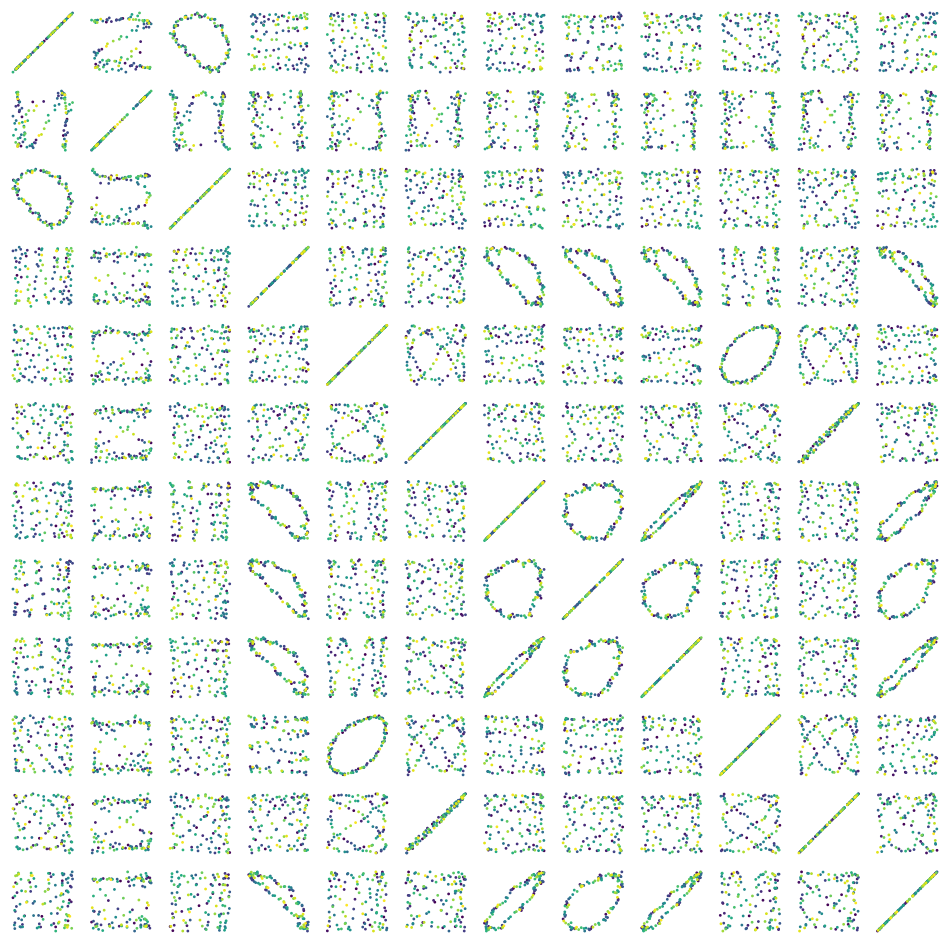

In [388]:
fig=plt.figure(0, (12,12))
for i in range(12):
    for j in range(12):
        fig.add_subplot(12,12,12*i+j+1)
        plt.scatter(mr[:, 0, 2, i], mr[:, 0, 2, j], c=range(113), s=1)
        plt.axis('off')

In [389]:
# fig=plt.figure(0, (12,12))
# for i in range(128):
#     fig.add_subplot(12, 12, i+1)
#     plt.imshow(mr[:,:,2,i]); plt.axis('off')

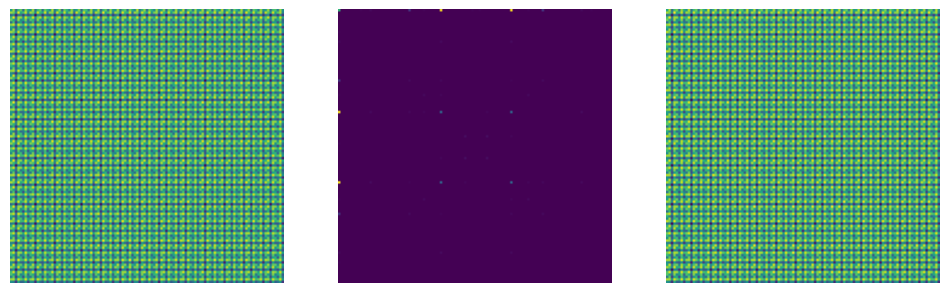

In [390]:
neuron_idx=2
F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,neuron_idx], num_freqs=64)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(F_sparse));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(x_hat); plt.axis('off');

In [391]:
components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)

In [392]:
print(code_str)

def approx_M(i, j):
    val = 0.426
    val += 1.292 * np.cos(2*np.pi*((42*i)/113) + -1.438)
    val += 1.292 * np.cos(2*np.pi*((42*j)/113) + -1.438)
    val += 0.434 * np.cos(2*np.pi*((42*i)/113) + -2.778) * np.cos(2*np.pi*((42*j)/113) + -2.778)
    val += 0.425 * np.cos(2*np.pi*((42*i)/113) + -3.142) * np.cos(2*np.pi*((71*j)/113) + -3.142)
    return val


In [393]:
def approx_M(i, j):
    val = 0.426
    val += 1.292 * np.cos(2*np.pi*((42*i)/113) + -1.438)
    val += 1.292 * np.cos(2*np.pi*((42*j)/113) + -1.438)
    val += 0.434 * np.cos(2*np.pi*((42*i)/113) + -2.778) * np.cos(2*np.pi*((42*j)/113) + -2.778)
    val += 0.425 * np.cos(2*np.pi*((42*i)/113) + -3.142) * np.cos(2*np.pi*((71*j)/113) + -3.142)
    return val

In [394]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

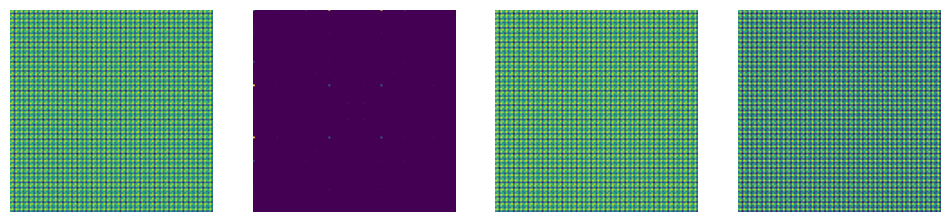

In [395]:
fig=plt.figure(0, (12, 6))
fig.add_subplot(1,4,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,4,2); plt.imshow(np.abs(F_sparse));  plt.axis('off')
fig.add_subplot(1,4,3); plt.imshow(x_hat); plt.axis('off');
fig.add_subplot(1,4,4); plt.imshow(m_approx); plt.axis('off');

### Search for good example neurons. 

In [396]:
# ---- Helper for classifying term type ----
def classify_term_type(kx, ky, is_dc):
    if is_dc:
        return "dc"
    if kx != 0 and ky == 0:
        return "row"
    if kx == 0 and ky != 0:
        return "col"
    if kx == 0 and ky == 0:
        return "dc"
    return "cross"  # kx != 0 and ky != 0


# ---- Loop over neurons and build DataFrame ----
all_rows = []

for neuron_idx in tqdm(range(512)):
    # 113 x 113 slice for this neuron
    m_slice = mr[:, :, 2, neuron_idx]

    components, Nx, Ny = compute_frequency_components(m_slice)
    terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)

    # Max amplitude (non-DC) for this neuron, for "strong" comparison later
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]
    max_amp = max((t["amplitude"] for t in non_dc_terms), default=0.0)

    for rank, t in enumerate(terms):
        is_dc = t.get("is_dc", False)
        kx = t["kx"]
        ky = t["ky"]
        amp = t["amplitude"]
        phase = t["phase"]

        term_type = classify_term_type(kx, ky, is_dc)

        all_rows.append({
            "neuron_idx": neuron_idx,
            "term_rank": rank,          # 0 = DC if include_dc=True
            "is_dc": is_dc,
            "term_type": term_type,     # "dc", "row", "col", "cross"
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase,
            "max_amp_neuron": max_amp,  # per neuron
        })

df = pd.DataFrame(all_rows)

100%|██████████████████████████████████| 512/512 [00:18<00:00, 27.34it/s]


In [397]:
df_c=df[df['term_type']=='cross']
df_c=df_c[df_c['kx']==42] #Freq filter
df_c=df_c[df_c['ky']==42]

Hmm no low frequency cross terms -> not great, might be ok tho, we'll see. 

In [398]:
df_c

neuron_idx  term_rank  is_dc term_type  kx  ky  amplitude     phase  \
3              0          3  False     cross  42  42   0.445090 -2.081404   
13             2          3  False     cross  42  42   0.433775 -2.777632   
63            12          3  False     cross  42  42   0.479471 -1.839608   
71            14          1  False     cross  42  42   0.139659  0.041202   
78            15          3  False     cross  42  42   0.554618 -1.841155   
...          ...        ...    ...       ...  ..  ..        ...       ...   
2478         495          3  False     cross  42  42   0.468464  2.821379   
2513         502          3  False     cross  42  42   0.455757 -2.467292   
2526         505          1  False     cross  42  42   0.223098  1.676000   
2538         507          3  False     cross  42  42   0.246311 -1.500234   
2558         511          3  False     cross  42  42   0.424264  3.062293   

      max_amp_neuron  
3           1.821897  
13          1.292308  
63          1.568940  
71          0.139659  
78          1.533901  
...              ...  
2478        1.195933  
2513        1.789568  
2526        0.223098  
2538        0.717412  
2558        1.929602  

[165 rows x 9 columns]

Ok bit of a technical issue here -> my current way of decomposing with the FFT locks the phases of my cross terms together, so I won't discover sin(x)cos(y) type terms -> however we can still make one of the trig identities work. I think this is probably fine for now and I should keep moving. 

In [399]:
df_c.sort_values(by='amplitude', ascending=False)[:15]

neuron_idx  term_rank  is_dc term_type  kx  ky  amplitude     phase  \
1128         225          3  False     cross  42  42   0.685110  2.334136   
2328         465          3  False     cross  42  42   0.613619  2.444687   
288           57          3  False     cross  42  42   0.613137 -1.785321   
293           58          3  False     cross  42  42   0.601186 -1.682347   
1323         264          3  False     cross  42  42   0.584519  2.280180   
263           52          3  False     cross  42  42   0.565218  2.184083   
2473         494          3  False     cross  42  42   0.559593 -1.814658   
2343         468          3  False     cross  42  42   0.557085 -2.028127   
1828         365          3  False     cross  42  42   0.556986  2.193389   
78            15          3  False     cross  42  42   0.554618 -1.841155   
1048         209          3  False     cross  42  42   0.544678  2.545807   
1738         347          3  False     cross  42  42   0.542249  2.486926   
1043         208          3  False     cross  42  42   0.539687 -2.419409   
1583         316          3  False     cross  42  42   0.537174 -1.994685   
238           47          3  False     cross  42  42   0.520064  2.261049   

      max_amp_neuron  
1128        1.630547  
2328        1.443183  
288         1.823264  
293         1.631269  
1323        1.699038  
263         1.680073  
2473        1.709527  
2343        1.603464  
1828        1.657570  
78          1.533901  
1048        1.957547  
1738        1.277649  
1043        1.977965  
1583        2.103536  
238         1.244519

In [400]:
import numpy as np
import pandas as pd
import itertools

df_filt=df_c

# --- If you haven't already, define fundamental frequencies ---
def fundamental_k(k, N):
    return min(k % N, (-k) % N)

Nx = 113  # or mr.shape[0]
Ny = 113  # or mr.shape[1]

if "kx_fund" not in df_filt.columns:
    df_filt["kx_fund"] = df_filt["kx"].apply(lambda k: fundamental_k(k, Nx))
    df_filt["ky_fund"] = df_filt["ky"].apply(lambda k: fundamental_k(k, Ny))

# --- Helper: wrap an angle difference into [-pi, pi) ---
def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Tolerance for "approximately pi/2"
tol = 0.1  # radians (~5.7 degrees), tune as needed

pairs = []

# Group by frequency and term_type so we're comparing like with like
group_cols = ["term_type", "kx_fund", "ky_fund"]
for key, g in df_filt.groupby(group_cols):
    term_type, kx_f, ky_f = key

    # Keep just (neuron_idx, phase), drop any duplicates
    g_small = g[["neuron_idx", "phase"]].drop_duplicates()

    # Iterate over all neuron pairs in this frequency group
    for (n1, p1), (n2, p2) in itertools.combinations(
        g_small.itertuples(index=False, name=None), 2
    ):
        dphi = wrap_to_pi(p1 - p2)

        # Check if the phase difference is close to ±pi/2
        if np.abs(np.abs(dphi) - (np.pi / 2)) <= tol:
            pairs.append({
                "neuron_1": n1,
                "neuron_2": n2,
                "term_type": term_type,
                "kx_fund": kx_f,
                "ky_fund": ky_f,
                "phase_1": p1,
                "phase_2": p2,
                "phase_diff": dphi,
            })

pairs_df = pd.DataFrame(pairs)


In [401]:
pairs_df

neuron_1  neuron_2 term_type  kx_fund  ky_fund   phase_1   phase_2  \
0           0        84     cross       42       42 -2.081404 -0.552554   
1           0        95     cross       42       42 -2.081404 -0.556467   
2           0       204     cross       42       42 -2.081404 -0.532268   
3           0       209     cross       42       42 -2.081404  2.545807   
4           0       294     cross       42       42 -2.081404  2.543106   
..        ...       ...       ...      ...      ...       ...       ...   
823       477       495     cross       42       42 -1.835369  2.821379   
824       485       494     cross       42       42  2.944147 -1.814658   
825       488       495     cross       42       42 -1.870244  2.821379   
826       489       511     cross       42       42 -1.564628  3.062293   
827       494       495     cross       42       42 -1.814658  2.821379   

     phase_diff  
0     -1.528850  
1     -1.524937  
2     -1.549137  
3      1.655975  
4      1.658675  
..          ...  
823    1.626437  
824   -1.524380  
825    1.591563  
826    1.656264  
827    1.647148  

[828 rows x 8 columns]

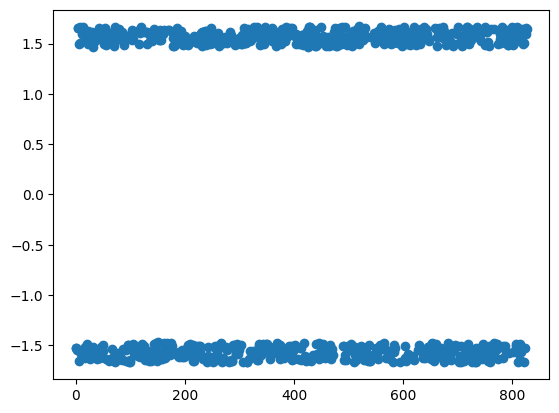

In [402]:
plt.scatter(np.arange(len(pairs_df)), pairs_df['phase_diff'])

Ah that's dope -> did not expect that natural phase differences are pi/2 in both directions. 

In [403]:
df_c['relative_amplitude']=df_c['amplitude']/df_c['max_amp_neuron']

In [404]:
df_c.sort_values(by='relative_amplitude', ascending=False)[:15]

neuron_idx  term_rank  is_dc term_type  kx  ky  amplitude     phase  \
1301         260          1  False     cross  42  42   0.275985 -0.327045   
2066         413          1  False     cross  42  42   0.152870 -0.348060   
1946         389          1  False     cross  42  42   0.155589  0.355670   
1951         390          1  False     cross  42  42   0.251851  0.412332   
1031         206          1  False     cross  42  42   0.158654  0.548054   
1021         204          1  False     cross  42  42   0.199581 -0.532268   
996          199          1  False     cross  42  42   0.254886 -0.325909   
976          195          1  False     cross  42  42   0.374034  1.040687   
1986         397          1  False     cross  42  42   0.442205  1.316249   
2391         478          1  False     cross  42  42   0.254433  0.891746   
946          189          1  False     cross  42  42   0.257237 -0.217791   
931          186          1  False     cross  42  42   0.314785 -0.304465   
1686         337          1  False     cross  42  42   0.272194 -1.538884   
2031         406          1  False     cross  42  42   0.125380  1.376759   
821          164          1  False     cross  42  42   0.209887 -0.876964   

      max_amp_neuron  kx_fund  ky_fund  relative_amplitude  
1301        0.275985       42       42                 1.0  
2066        0.152870       42       42                 1.0  
1946        0.155589       42       42                 1.0  
1951        0.251851       42       42                 1.0  
1031        0.158654       42       42                 1.0  
1021        0.199581       42       42                 1.0  
996         0.254886       42       42                 1.0  
976         0.374034       42       42                 1.0  
1986        0.442205       42       42                 1.0  
2391        0.254433       42       42                 1.0  
946         0.257237       42       42                 1.0  
931         0.314785       42       42                 1.0  
1686        0.272194       42       42                 1.0  
2031        0.125380       42       42                 1.0  
821         0.209887       42       42                 1.0

In [405]:
neuron_idx=260
F = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.793
    val += 0.276 * np.cos(2*np.pi*((42*i)/113) + -0.327) * np.cos(2*np.pi*((42*j)/113) + -0.327)
    val += 0.228 * np.cos(2*np.pi*((42*i)/113) + 0.0) * np.cos(2*np.pi*((71*j)/113) + 0.0)
    val += 0.124 * np.cos(2*np.pi*((29*i)/113) + -2.742)
    val += 0.124 * np.cos(2*np.pi*((29*j)/113) + -2.743)
    return val


In [408]:
def approx_M(i, j):
    val = 0.793
    val += 0.276 * np.cos(2*np.pi*((42*i)/113) + -0.327) * np.cos(2*np.pi*((42*j)/113) + -0.327)
    val += 0.228 * np.cos(2*np.pi*((42*i)/113) + 0.0) * np.cos(2*np.pi*((71*j)/113) + 0.0)
    val += 0.124 * np.cos(2*np.pi*((29*i)/113) + -2.742)
    val += 0.124 * np.cos(2*np.pi*((29*j)/113) + -2.743)
    return val

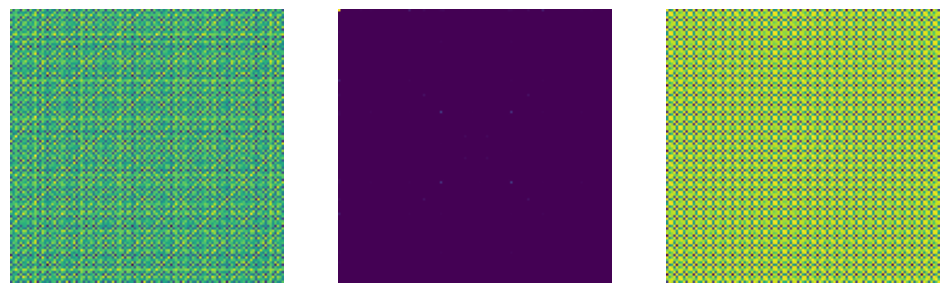

In [409]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(F));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

- Ok jeez feel like I'm maybe overthinking a bit.
- The ones that have the strongest cross terms are definitely interesting
- Reconstruction seems not amazing -> but I'll probably use a 3D version?
- Also unsure on this frequency still -> ehh let me just get a couple out and I can come back.
- Ok cool yeah line in sand here, let's do 260 and 397. Come back and change later if these don't work out. 

In [377]:
neuron_idx=397
F = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 1.008
    val += 0.442 * np.cos(2*np.pi*((42*i)/113) + 1.316) * np.cos(2*np.pi*((42*j)/113) + 1.316)
    val += 0.224 * np.cos(2*np.pi*((42*i)/113) + -0.0) * np.cos(2*np.pi*((71*j)/113) + -0.0)
    val += 0.205 * np.cos(2*np.pi*((29*i)/113) + 1.765)
    val += 0.205 * np.cos(2*np.pi*((29*j)/113) + 1.766)
    return val


In [378]:
def approx_M(i, j):
    val = 0.686
    val += 0.266 * np.cos(2*np.pi*((42*i)/113) + 0.954) * np.cos(2*np.pi*((42*j)/113) + 0.954)
    val += 0.207 * np.cos(2*np.pi*((42*i)/113) + -0.0) * np.cos(2*np.pi*((71*j)/113) + -0.0)
    val += 0.117 * np.cos(2*np.pi*((29*i)/113) + 2.126)
    val += 0.117 * np.cos(2*np.pi*((29*j)/113) + 2.127)
    return val

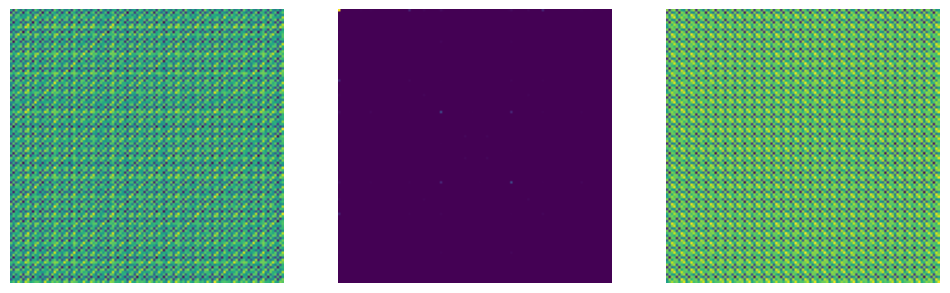

In [379]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(F));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

In [380]:
mr.shape

(113, 113, 3, 512)

In [381]:
np.save('/home/stephen/grokking/nov_25_1/mlp_hook_pre', mr)

## 3. Fancy Trig

Show a spot or two where the network is clearly adding product terms together to cancel out some symmetry and create diagonal symmetry -> big deal! Depending on how part (2) goes, try manim surface again. Again I want analytical fit equation/approximation. 

so fancy trig needs to be `blocks.0.mlp.hook_post`, or `blocks.0.mlp.hook_pre`, or thier functional equivalents. 

Ok struggle bus this morning, but getting close -> so I have nice examples above of: 

```
0.276 * np.cos(2*np.pi*((42*i)/113) + -0.327) * np.cos(2*np.pi*((42*j)/113) + -0.327)
```
and
```
val += 0.442 * np.cos(2*np.pi*((42*i)/113) + 1.316) * np.cos(2*np.pi*((42*j)/113) + 1.316)
```

which give me nice cos cos and sin sin terms. 

Ok ok ok ok ok ok ok ok. Now, later in the model - I want to find evidence of the difference of these terms collapsing. That's my next step. 

Ah we can do a quick gut check like this too - I'm thinking the animated version of this would be nice/dope

In [410]:
m_diff=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_diff[i,j]=np.cos(2*np.pi*((42*i)/113) + -0.327) * np.cos(2*np.pi*((42*j)/113) + -0.327) - \
                    np.cos(2*np.pi*((42*i)/113) + 1.316) * np.cos(2*np.pi*((42*j)/113) + 1.316)

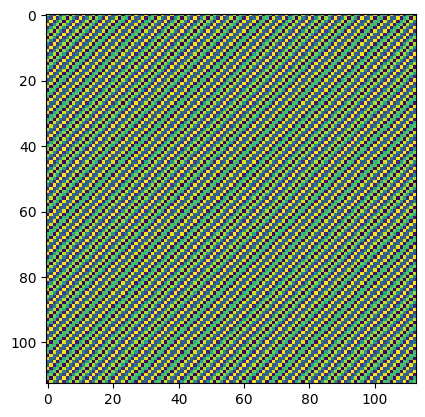

In [411]:
plt.imshow(m_diff)

Ah yep -> that's dope. I think that will be visually satisfying. 

In [382]:
mr = einops.rearrange(cache['blocks.0.hook_mlp_out'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()
mr.shape

(113, 113, 3, 128)

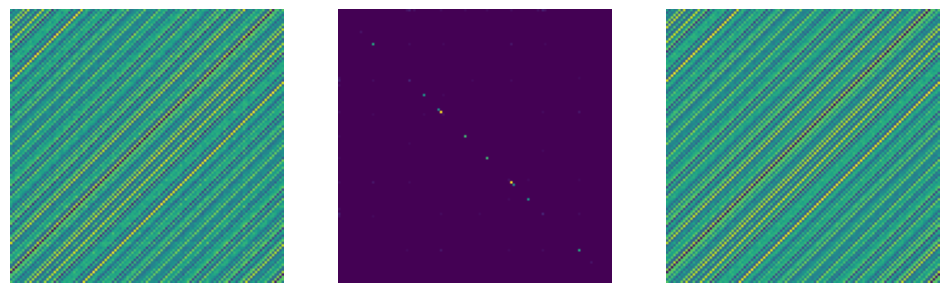

In [168]:
neuron_idx=8
F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,neuron_idx], num_freqs=64)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(F_sparse));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(x_hat); plt.axis('off');

In [181]:
# Ok no go on scatter plot here I think
# fig=plt.figure(0, (12,12))
# for i in range(12):
#     for j in range(12):
#         fig.add_subplot(12,12,12*i+j+1)
#         plt.scatter(mr[:5, :, 2, i+36].ravel(), mr[:5, :, 2, j+36].ravel(), s=1, alpha=0.5) #, c=range(113), s=1)
#         plt.axis('off')

## 4. Logits/outputs
- Ok I need to show that the trig products from (3) are being multiplied by cos(wc) and sin(wc) - the c part is important. Let me check if I can do with just WU first. And if not, then W_logit.
- Grr questioning this now a little. 

In [77]:
W_U.shape

torch.Size([128, 113])

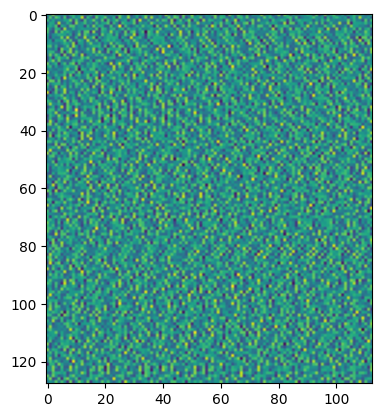

In [78]:
plt.imshow(W_U.detach().cpu().numpy())

Ok yeah nah bro. 

In [79]:
W_logit.shape

torch.Size([512, 113])

In [87]:
m=W_logit.detach().cpu().numpy()

<Figure size 640x480 with 0 Axes>

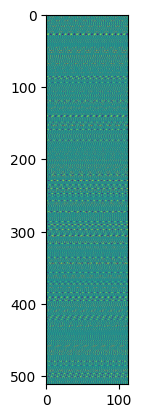

In [88]:
plt.imshow(m)
plt.savefig('/home/stephen/grokking/nov_25_1/w_logit_1.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_67234/3417425180.py:3: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (12,12))


<Figure size 640x480 with 0 Axes>

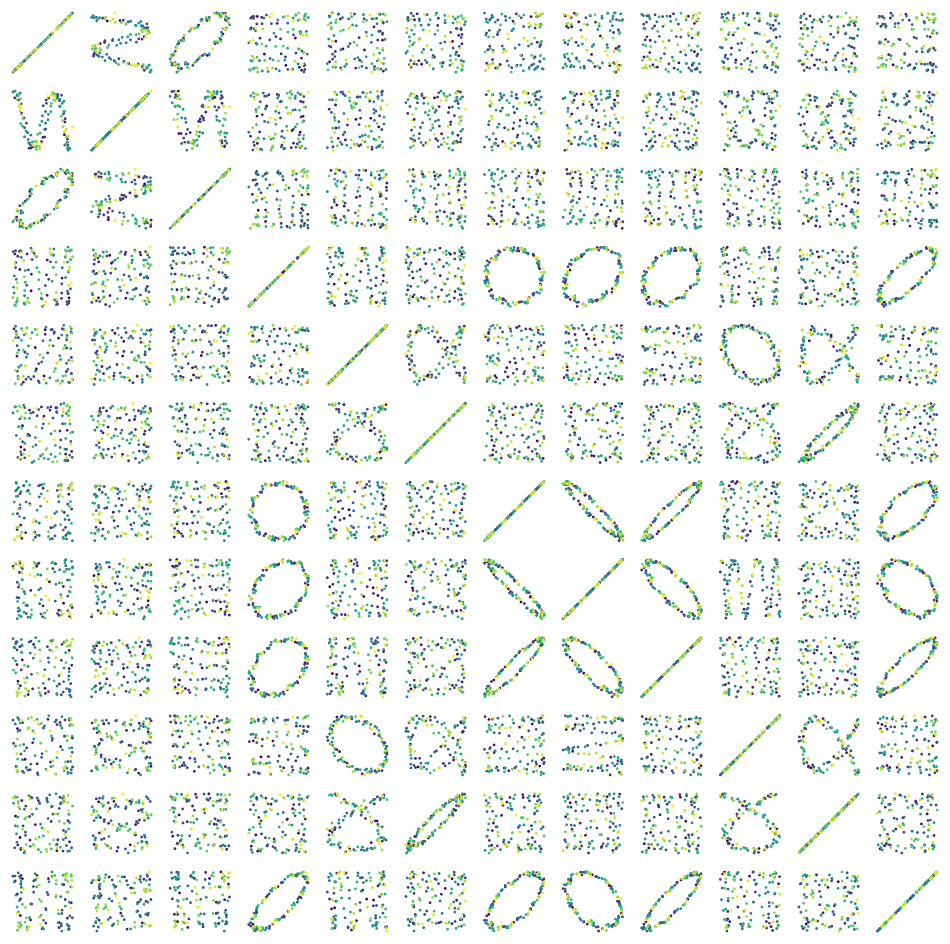

In [84]:
for fig_count in range(8): 
    plt.clf()
    fig=plt.figure(0, (12,12))
    for i in range(12):
        for j in range(12):
            fig.add_subplot(12,12,12*i+j+1)
            plt.scatter(m[i, :], m[j, :], c=range(113), s=1)
            plt.axis('off')
    plt.savefig('/home/stephen/grokking/nov_25_1/w_logit_scatter_'+str(fig_count)+'.png', dpi=300, bbox_inches='tight')

In [85]:
# fig=plt.figure(0, (12,12))
# for i in range(12):
#     for j in range(12):
#         fig.add_subplot(12,12,12*i+j+1)
#         plt.scatter(m[i, :], m[j, :], c=range(113), s=1)
#         plt.axis('off')

In [90]:
head_index=1
res=[]
for neuron_idx in range(512):
    sig=m[neuron_idx, :]
    
    F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
    terms_1d = spectrum_to_terms_1d(F_sparse)
    terms_1d[0]['neuron_idx']=neuron_idx
    terms_1d[0]['err']=np.linalg.norm(sig-x_hat)/np.linalg.norm(sig)
    res.append(terms_1d[0])
df=pd.DataFrame(res)

In [92]:
df_k14 = df[df["k"] == 14]
df_k14.iloc[df_k14['err'].argsort()][:10]

k  amplitude     phase  neuron_idx       err
86   14   0.388829 -1.441011          86  0.112342
501  14   0.403922  0.620775         501  0.115331
291  14   0.474096  0.497690         291  0.115400
287  14   0.451101  1.701512         287  0.116067
241  14   0.462269  0.807927         241  0.116512
385  14   0.421845 -1.568069         385  0.116677
357  14   0.389860  1.702919         357  0.116697
273  14   0.468869 -2.390621         273  0.117543
497  14   0.393708 -0.683721         497  0.118811
236  14   0.466807  2.656673         236  0.119211

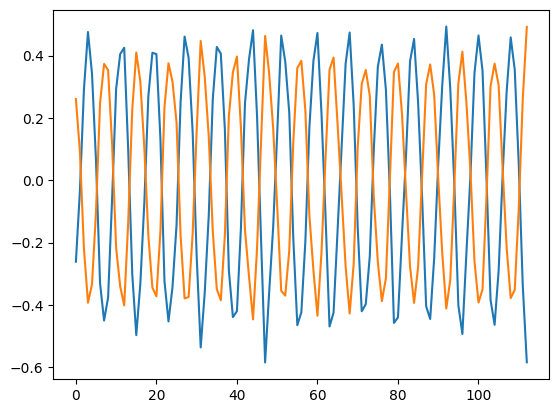

In [95]:
plt.plot(m[273, :])
plt.plot(m[501, :])

Nice!

In [93]:
np.save('/home/stephen/grokking/nov_25_1/W_lotit', m)